In [1]:
import h5py
import numpy as np
from scipy.io import loadmat
from fw_i2cm1i_graphcut import fw_i2cm1i_graphcut
from fwFit_ComplexLS_1r2star import fwFit_ComplexLS_1r2star
from computeFF import computeFF
from create_robust_mask import create_robust_mask

In [2]:

# Open the HDF5 file
file = h5py.File('/home/dxt005/home/Tools/WaterFatPython/Data/invivo/IdealChanCombData_16415_2.h5', 'r')
#file = h5py.File('/home/dxt005/home/Tools/WaterFatPython/Data/invivo_FF10p/IdealChanCombData_25544_4.h5', 'r')
#file = h5py.File('/home/dxt005/home/DATA/EXAM_6682_UWMR7.mr.med.ge.com_2024_05_14/IDEAL/IdealChanCombData_6682_2.h5', 'r')


xres = file['Header']['ImageXRes'][0]
yres = file['Header']['ImageYRes'][0]
nslices = file['Header']['NumSlices'][0]
nTE = file['Header']['NumEchoes'][0]
TEs = file['Header']['EchoTimes'][0:nTE]
FieldStrength = file['Header']['FieldStrength'][0]

ims = np.zeros((xres, yres, nTE, nslices), dtype=np.cdouble)

# Iterate over each key
for sl in range(len(file['Data'].keys())):
    # Get the data
    key = 'Slice%d' % (sl)
    data = np.array(list(file['Data'][key]))
    data_c = data['real'] + 1j*data['imag']
    ims[:,:,:,sl] = data_c.transpose((2,1,0))

ims = 100.0*ims/np.max(np.abs(ims))


In [39]:

# Setup params
PROCESS_PHANTOM = 0


fatAmps = np.array([0.087, 0.693, 0.128, 0.004, 0.039, 0.048])
fatFreq = np.array([-3.80, -3.40, -2.60, -1.94, -0.39, 0.60])
if PROCESS_PHANTOM==1:
	fatFreq = fatFreq - 0.08

algoParams = {
    'species': [
        {
            'name': 'water',
            'frequency': np.array([0.0]),
            'relAmps': np.array([1.0])
        },
        {
            'name': 'fat',
            'frequency': fatFreq,
            'relAmps': fatAmps
        }
    ],
    'size_clique':1,
    'range_r2star':np.array([0, 1000]),
    'NUM_R2STARS':11,
    'range_fm':np.array([-600, 600]),
    'NUM_FMS':101,
    'NUM_ITERS':40,
    'SUBSAMPLE':4,#4
    'DO_OT':0,
    'LMAP_POWER':2,
    'lambda':0.02,
    'LMAP_EXTRA':0.02,
    'TRY_PERIODIC_RESIDUAL':0
}

imDataParams = {
    'TE': TEs,
    'FieldStrength':FieldStrength/10000.0,
    'PrecessionIsClockwise': -1,
    'images':np.array([0, 0])
}

In [40]:

import time

R2s3D = np.zeros((xres, yres, nslices))
PDFF3D = np.zeros((xres, yres, nslices))
Water3D = np.zeros((xres, yres, nslices))
Fat3D = np.zeros((xres, yres, nslices))
FM3D = np.zeros((xres, yres, nslices))

for sl in range(20,21):#range(nslices):

    print('Slice %d'%(sl))
      
    imDataParams['images'] = ims[:,:,:,sl].reshape(xres, yres, 1, 1, nTE,1)
    
    mask = create_robust_mask(np.abs(ims[:,:,0,sl]), percentile_low=0, percentile_high=50)  
    
    start = time.time()
    initParams = fw_i2cm1i_graphcut(imDataParams, algoParams)
    initParams['masksignal'] = mask
    end = time.time()
    print("Process Time initParams: %f" % (end - start))

    start = time.time()
    outParams = fwFit_ComplexLS_1r2star(imDataParams, algoParams, initParams)
    end = time.time()
    print("Process Time fwFit_ComplexLS_1r2star: %f" % (end - start))
          
    R2s3D[:,:,sl] = outParams['r2starmap']
    PDFF3D[:,:,sl] = computeFF( outParams )
    Water3D[:,:,sl] = outParams['water_amp']
    Fat3D[:,:,sl] = outParams['fat_amp']
    FM3D[:,:,sl] = outParams['fm']




Slice 20
Process Time estimateR2starGivenFieldmap: 1.084130
Process Time decomposeGivenFieldMapAndDampings: 1.700797
Process Time initParams: 4.483653
Process Time fwFit_ComplexLS_1r2star: 2.863967


/tmp/ipykernel_453790/2275501167.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  Water3D[:,:,sl] = outParams['water_amp']
/tmp/ipykernel_453790/2275501167.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  Fat3D[:,:,sl] = outParams['fat_amp']


In [22]:
FieldStrength/10000.0

1.5

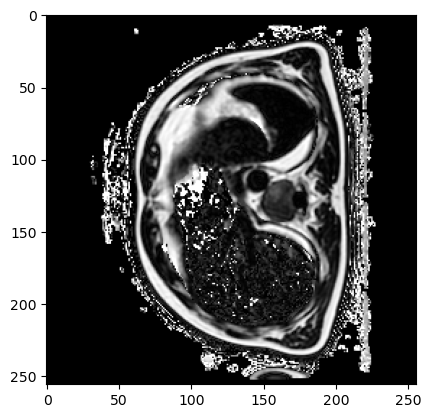

In [43]:
import matplotlib.pyplot as plt
plt.imshow(np.abs(PDFF3D[:,:,20]), cmap='gray',vmin=0, vmax=100)
plt.show()


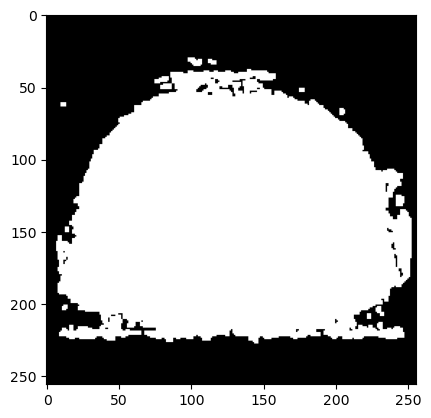

In [42]:
import matplotlib.pyplot as plt
plt.imshow(initParams['masksignal'][:,:], cmap='gray',vmin=0, vmax=1)
plt.show()


In [39]:
TEs

array([0.001992, 0.004   , 0.006008, 0.008016, 0.010024, 0.012032])

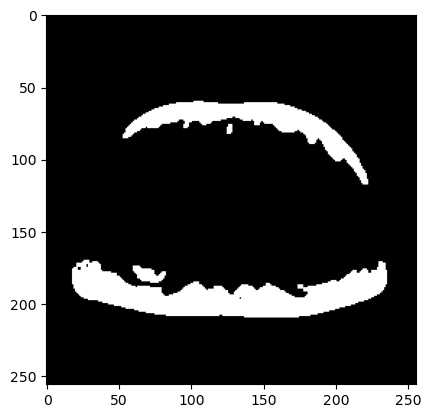

In [35]:
mask = create_robust_mask(np.abs(ims[:,:,0,20]), percentile_low=0, percentile_high=50)

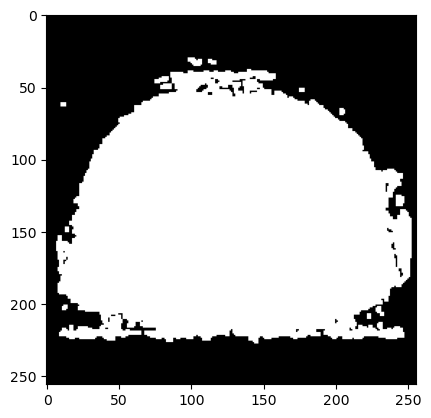

In [36]:
import matplotlib.pyplot as plt
plt.imshow(mask, cmap='gray')
plt.show()
